### 基础库导入

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from typing import Union
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
import joblib


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\BrainC\brainc_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\BrainC\brainc_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "d:\BrainC\brainc_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\BrainC\brainc_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\BrainC\brainc_env\lib\site-packages\ipykernel\kern

AttributeError: _ARRAY_API not found

### 路径定义

In [3]:
root = '.'
# raw_data_root = os.path.join(root, 'None')
data_folder = os.path.join(root, 'dataset')
fc_data_folder = os.path.join(data_folder, 'fc_data')
math_data_url = os.path.join(data_folder, 'math_data')
fc_residual_data_folder = os.path.join(data_folder, 'fc_residual_data')
projection_url = os.path.join(root, 'references', 'networks_projection.csv')
img_save_folder = os.path.join(root, 'imgs')
model_folder = os.path.join(root, 'models')

### 环境变量

In [4]:
NODES_RANGE = range(1, 269)
NETWORKS = {1: 'Medial frontal', 2: 'Frontoparietal', 3: 'Default mode', 4: 'Subcortical-cerebellum', 5: 'Motor', 6: 'Visual I', 7: 'Visual Ⅱ', 8: 'Visual association'}
# 矩阵按照下三角组合的索引对，转为list如(e.g. [0-1, 0-2, ...])
LOWER_TRIANGULAR_IDX = [f'{i}-{j}' for i in range(1, 269) for j in range(i+1, 269)]
FC_KEYS = ['FC_mat']
MATH_KEYS = {'math': ['behav_math'], 'ID': ['cov_ID2'], 'gender': ['cov_gender'], 'grade': ['cov_grade']}

In [5]:
# 获取映射关系
projection = pd.read_csv(projection_url)
projection.head()

,Node,Network
0,1,2
1,2,4
2,3,3
3,4,2
4,5,3


### 函数定义

In [6]:
# # 从Excel数据中提取特定表数据
# def get_slice_fc(fc_bart:pd.DataFrame, slice:int):
#     """
#     Describe:
#         get fc of a slice from fc_bart.
#     Input:
#         fc_bart: pd.DataFrame
#         slice: int
#     Output:
#         sheet: pd.DataFrame
#     """
#     # get all sheet names
#     slice_names = fc_bart.sheet_names
#     slice_name = 'Slice_' + str(slice)
#     if slice_name not in slice_names:
#         raise ValueError(f'Slice not found, Slice from {slice_names[1]} to {slice_names[-1]}')
#     # get the sheet of the slice
#     sheet = fc_bart.parse(slice_name, header=None)
#     # set headers and idx like 'Voxel1'
#     sheet.columns = ['Voxel' + str(i) for i in range(1, sheet.shape[1] + 1)]
#     sheet.index = ['Voxel' + str(i) for i in range(1, sheet.shape[0] + 1)]
    
#     return sheet

In [7]:
# # 加载数据
# def load_data(data_path: str) -> pd.DataFrame:
#     if not os.path.exists(data_path):
#         raise FileNotFoundError(f"file not found: {data_path}")
    
#     if data_path.endswith(".csv"):
#         df = pd.read_csv(data_path)
#     elif data_path.endswith(".xlsx"):
#         df = pd.ExcelFile(data_path)
#         if len(df.sheet_names) == 1:
#             df = df.parse(df.sheet_names[0], header=None)
    
#     return df

In [8]:
# 获取指定目录下的所有文件名
def get_files(path: str, suffix: Union[str, list]=None) -> list:
    """
    Describe:
        get all files under the path with the specified suffix.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"file not found: {path}")
    
    if isinstance(suffix, str):
        suffix = [suffix]
    if suffix is None:
        suffix = []
    
    files = []
    for root, dirs, filenames in os.walk(path):
        for filename in filenames:
            if filename.split('.')[-1] in suffix:
                files.append(os.path.join(root, filename))

    return files

In [9]:
# 读取.mat数据
def load_mat(mat_path: str, *args) -> np.array:
    """
    Describe:
        load .mat file to numpy array.
    Input:
        mat_path: str
    Output:
        data: np.array
    """
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"file not found: {mat_path}")
    
    mat = loadmat(mat_path)

    # # 打印各个变量的维度
    # for key, value in mat.items():
    #     if isinstance(value, np.ndarray):
    #         print(f"{key}: {value.shape}")
    # return

    # transform to numpy array
    if len(args) == 1:
        data = mat[args[0]]
    elif len(args) > 1:
        data = {key:mat[key] for key in args}
    else:
        data = mat
    
    return data

In [10]:
# 将numpy array转为pandas DataFrame
def array2df(data: np.array, columns:list=None, 
idx:list=None) -> pd.DataFrame:
    """
    Describe:
        transform numpy array to pandas DataFrame.
    Input:
        data: np.array
        columns: list
        idx: list
    Output:
        df: pd.DataFrame
    """
    if isinstance(data, np.ndarray):
        # check dimensions
        if data.ndim > 2:
            raise ValueError(f"Data dimensions should be less than 3, but got {data.ndim}: {data.shape}")
        
        if columns:
            if len(columns) != data.shape[1]:
                raise ValueError(f"Columns length should be equal to data's second dimension{data.shape[1]}, but got {len(columns)}")
        if idx:
            if len(idx) != data.shape[0]:
                raise ValueError(f"Index length should be equal to data's first dimension{data.shape[0]}, but got {len(idx)}")
            
        df = pd.DataFrame(data, columns=columns, index=idx)
    else:
        raise TypeError(f"Data type should be np.ndarray, but got {type(data)}")
    
    return df

In [11]:
# 取对称矩阵的下三角元素并将元素展平为一维
def flatten_lower_triangle(matrix: np.array) -> np.array:
    """
    Describe:
        flatten lower triangle of a matrix.
    Input:
        matrix: np.array
    Output:
        flatten_matrix: np.array
    """
    if matrix.ndim != 2:
        raise ValueError(f"Matrix dimensions should be 2, but got {matrix.ndim}")
    
    # get lower triangle index
    idx = np.tril_indices(matrix.shape[0], -1)
    flatten_matrix = matrix[idx]
    
    return flatten_matrix

In [12]:
# 提取数据下三角元素并展平拼接
def merge_lower_triangle(data: np.array) -> pd.DataFrame:
    """
    Describe:
        merge lower triangle of each matrix in data.
    Input:
        data: np.array
    Output:
        flatten_data: pd.DataFrame
    """
    if data.ndim != 3:
        raise ValueError(f"Data dimensions should be 3, but got {data.ndim}")
    
    # 将fc_bart下三角阵展平并合并
    for i in range(1, data.shape[2]):
        flatten = np.vstack([flatten_lower_triangle(data[:, :, i]) for i in range(data.shape[2])])
    flatten = array2df(flatten, columns=LOWER_TRIANGULAR_IDX)
    
    return flatten


In [13]:
# 将对称的fc矩阵变为下三角阵，上三角阵置为0
def reset_fc_matrix(fc_matrix: Union[pd.DataFrame, np.ndarray]):
    """
    Describe:
        reset fc matrix to lower triangle matrix.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    n = fc_matrix.shape[0]
    new_fc_matrix = fc_matrix.copy()
    for i in range(n):
        for j in range(i+1, n):
            new_fc_matrix[j, i] = 0
    return pd.DataFrame(new_fc_matrix)

In [14]:
# 使用fsl绘制fc矩阵的热图
def plot_fc_heatmap(fc_matrix: Union[pd.DataFrame, np.ndarray], xlabel:str=None, ylabel:str=None, title:str='default', output:str=None):
    """
    Describe:
        plot fc matrix heatmap.
    Args:
        fc_matrix: pd.DataFrame or np.ndarray
        output: str
    """
    if isinstance(fc_matrix, pd.DataFrame):
        # 处理DataFrame类型的fc_matrix
        pass
    elif isinstance(fc_matrix, np.ndarray):
        # 处理ndarray类型的fc_matrix
        pass
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(fc_matrix, cmap='coolwarm', center=0, square=True)

    if xlabel:
        plt.xlabel(xlabel)
        plt.xticks([])
    if ylabel:
        plt.ylabel(ylabel)
        plt.yticks([])

    plt.title(title)

    if output:
        if not output.endswith('.png'):
            output += '.png'
        plt.savefig(output)
    # plt.close()

In [74]:
# node到network的映射方法
def node2network(projection_set:pd.DataFrame, nodes:list=None, networks:list=None, only_idx:bool=True, data:pd.DataFrame=None, flatten:bool=False)->Union[pd.DataFrame|tuple]:
    """
    Describe:
        node to network mapping.
        if set node, return the network of the node.
        if set n_networks, return the nodes of the network.
        if only_idx is True, only return the corresponding index of input.
        if data is set, return the corresponding data of the input with its shape.
    Args:
        projection_set: pd.DataFrame
        node: int
        n_networks: int
        only_idx: bool
        data: pd.DataFrame
        faltten: bool (whether data input is flatten)
    Returns:
        pd.DataFrame, tuple
    """
    if nodes is not None and networks is not None:
        raise ValueError("node and networks cannot be set at the same time.")
    
    if nodes is not None:
        if only_idx:
            unique_q = list(set(nodes))
            belongings = {}
            # 以network为key，node为value，构建字典
            for network in NETWORKS.keys():
                temp = projection_set[projection_set['Network'] == network]
                belongings[network] = temp[temp['Node'].isin(unique_q)]['Node'].unique()
            return belongings
        else:
            ...

    elif networks is not None:
        if only_idx:
            unique_q = list(set(networks))
            belongings = {}
            for network in unique_q:
                if network not in NETWORKS.keys():
                    raise ValueError(f"Network {network} not found.")
                belongings[network] = projection_set[projection_set['Network'] == network]['Node'].unique()
            return belongings
        else:
            ...
    

In [16]:
# 保存模型
def save_model(model, name_rule:str='model', sub_folder:str='', save_folder:str=model_folder):

    if not os.path.exists(save_folder):
        raise FileNotFoundError(f"folder not found: {save_folder}")
    
    if not os.path.exists(sub_folder) and sub_folder:
        os.makedirs(sub_folder)

    if isinstance(model, list):
        for i, m in enumerate(model):
            joblib.dump(m, os.path.join(save_folder, sub_folder, f'{name_rule}_{i+1}.pkl'))
    else:
        joblib.dump(model, os.path.join(save_folder, sub_folder, f'{name_rule}.pkl'))
    

### 数据概览

In [54]:
# get files
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [55]:
# load data
fc_bart = load_mat(fc_files[1], *FC_KEYS)
math_scores = load_mat(math_files[1], *MATH_KEYS['math'])
fc_bart.shape, math_scores.shape

((268, 268, 300), (300, 1))

In [56]:
# transform to DataFrame
fc_bart0 = array2df(fc_bart[:, :, 0], columns=NODES_RANGE, idx=NODES_RANGE)
math_scores = array2df(math_scores, columns=['math'])
fc_bart0.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
1,0.000000,-0.134212,0.173157,0.104981,0.085369,-0.054657,0.133306,0.247122,0.367899,-0.064801,...,0.237436,0.215343,0.051870,0.206197,0.196908,0.166484,0.243988,0.008609,0.478688,-0.100761
2,-0.134212,0.000000,0.227494,0.251627,0.069518,0.204896,0.208686,0.075589,0.084577,0.098416,...,-0.200088,-0.238993,0.178875,0.065824,-0.166461,-0.270812,0.143404,-0.011739,-0.296496,0.124123
3,0.173157,0.227494,0.000000,0.333182,0.233398,0.180528,0.144632,-0.049372,0.049068,0.097894,...,0.047772,-0.157287,0.230667,0.126153,-0.095713,-0.417319,0.306749,-0.040966,-0.043232,0.016863
4,0.104981,0.251627,0.333182,0.000000,-0.092764,0.081935,0.295651,0.226443,0.423303,0.002452,...,-0.044735,0.223942,0.115371,0.288373,0.365413,0.130634,0.269977,0.021065,-0.038831,0.345634
5,0.085369,0.069518,0.233398,-0.092764,0.000000,0.458606,-0.020393,0.029129,-0.004345,0.703778,...,0.385358,-0.099475,0.126898,0.239115,-0.143319,-0.259855,-0.037367,-0.065286,0.226203,0.059890


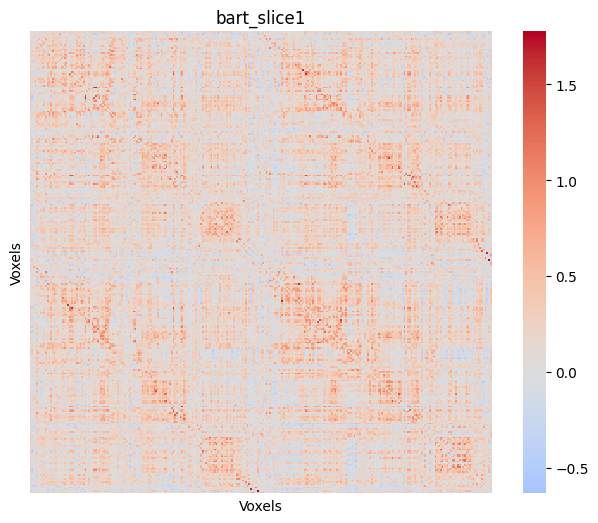

In [57]:
plot_fc_heatmap(fc_bart0, xlabel='Voxels', ylabel='Voxels', title='bart_slice1', output=os.path.join(img_save_folder, 'bart_slice1.png'))

In [58]:
math_scores.head()

,math
0,558.50
1,510.24
2,558.50
3,393.82
4,477.30


In [59]:
math_scores.describe()

,math
count,300.000000
mean,533.609833
std,99.473179
min,292.990000
25%,461.620000
50%,522.680000
75%,603.740000
max,795.010000


In [ ]:
# test of projection between node and network
results = node2network(
    projection_set=projection,
    nodes=None,
    networks=[1, 2, 3],
    only_idx=True,
    data=None,
    flatten=False
)
results

{1: array([ 10,  12,  16,  52,  53,  54,  56,  57,  64,  65, 137, 140, 145,
        148, 149, 150, 151, 153, 156, 162, 165, 183, 185, 186, 187, 190,
        192, 194, 219]),
 2: array([  1,   4,   7,   8,   9,  14,  17,  19,  21,  22,  30,  31,  47,
         48,  55,  70, 111, 112, 116, 139, 142, 143, 147, 154, 157, 164,
        182, 184, 193, 196, 199, 242, 246, 247]),
 3: array([  3,   5,   6,  13,  49,  50,  85,  86,  90,  96, 115, 134, 138,
        141, 203, 222, 223, 225, 227, 239])}

### 新方法

Idea:


#### 库导入

In [76]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from copy import deepcopy

#### Methods

In [77]:
def regress_out_covariates(data: np.array, *covariates) -> pd.DataFrame:
    """
    Describe:
        regress out covariates from data.
    Input:
        data: np.array
        covariates: np.array
    Output:
        residuals: pd.DataFrame
    """

    # 将fc_bart下三角阵展平并合并
    lower_triangle_fc = merge_lower_triangle(data)
    
    # 合并协变量
    cov = np.stack([covariate for covariate in covariates], axis=1).squeeze(-1)
    cov = array2df(cov, columns=list(MATH_KEYS.keys())[-2:])
    print(lower_triangle_fc.shape, cov.shape)

    residuals = pd.DataFrame(index=lower_triangle_fc.index, columns=lower_triangle_fc.columns)
    # 遍历每个下三角元素
    for column in lower_triangle_fc.columns:
        y = lower_triangle_fc[column]
        X = sm.add_constant(cov)
        model = sm.OLS(y, X).fit()
        residuals[column] = model.resid
    
    return residuals

In [78]:
# 交叉验证
def fold_cv(model=None, X:pd.DataFrame=None, y:pd.DataFrame=None, n_splits:int=5,score_method:str='neg_mean_squared_error')->tuple:
    """
    Describe:
        10-fold cross validation.
    Input:
        model: sklearn model
        X: pd.DataFrame
        y: pd.DataFrame
        n_splits: int
        score_method: str
    Output:
        scores: list
        mean_score: float
        std_score: float
    """
    if not model:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 计算交叉验证得分
    cv_scores = cross_val_score(
        model, 
        X, 
        y, 
        cv=kf, 
        scoring=score_method)
    
    return cv_scores, np.mean(cv_scores), np.std(cv_scores)
    

In [79]:
# 训练模型
def train_model(X:pd.DataFrame, y:pd.DataFrame, model=None, test_size:float=0.2, group_num:int=100):
    """
    Describe:
        train model.
    Input:
        X: pd.DataFrame
        y: pd.DataFrame
        model: sklearn model
        test_size: float
        group_num: int
    Output:
        models: list
        mean_score: float
        std_score: float
    """
    if model is None:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    models = []
    r2_scores = []
    for i in range(group_num):
        model_copy = deepcopy(model)
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        model_copy.fit(X_train, y_train)
        # 计算测试集得分
        r2_scores.append(r2_score(y_test, model_copy.predict(X_test)))
        models.append(model_copy)
    print(f"mean r2 score: {np.mean(r2_scores)}, std r2 score: {np.std(r2_scores)}")
    
    return models

In [80]:
# 多种组合训练模型并返回平均得分与标准差
def group_train_cv_val(model, X:Union[pd.DataFrame|dict], y:Union[pd.DataFrame|dict], test_size:float=0.2, group_num:int=100, n_splits:int=10, score_method:str='neg_mean_squared_error')->Union[tuple|dict]:
    """
    Describe:
        多种组合训练模型并返回平均得分与标准差
    Input:
        model: sklearn model
        X: pd.DataFrame or dict
        y: pd.DataFrame or dict
        test_size: float
        group_num: int
        n_splits: int
        score_method: str
    Output:
        tuple(models, (mean_scores, std_scores), mean_score, std_score)
         or 
        dict(key:(models, mean_temp, mean_score, std_score))
    """

    if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
        models = train_model(
            X=X, 
            y=y, 
            model=model, 
            test_size=test_size, 
            group_num=group_num)
        
        mean_scores = []
        std_scores = []
        for model in tqdm(models):
            scores, mean_score, std_score = fold_cv(
                model=model, 
                X=X, 
                y=y, 
                n_splits=n_splits,
                score_method=score_method)
            mean_scores.append(mean_score)
            std_scores.append(std_score)

        return (models, (mean_scores, std_scores), np.mean(mean_scores), np.std(mean_scores))
    
    elif isinstance(X, dict) and isinstance(y, dict):
        scores = {key:[] for key in X.keys()}
        print(f'total {len(X.keys())} groups to train.')

        for key in X.keys():
            models = train_model(
                X=X[key], 
                y=y[key], 
                model=model, 
                test_size=0.2, 
                group_num=100)
            
            mean_temp = []
            for model in tqdm(models):
                scores, mean_score, std_score = fold_cv(
                    model=model, 
                    X=X[key], 
                    y=y[key], 
                    n_splits=10,
                    score_method='neg_mean_squared_error')
                mean_temp[key].append(mean_score)
            
            scores[key] = (models, mean_temp, np.mean(mean_temp), np.std(mean_temp))
        
        return scores

    else:
        raise ValueError("X and y should be both pd.DataFrame or dict.")


#### Pipline

##### 加载原始数据

In [ ]:
# 读取数据
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [ ]:
fc_ant = load_mat(fc_files[0], *FC_KEYS)
fc_bart = load_mat(fc_files[1], *FC_KEYS)
fc_em = load_mat(fc_files[2], *FC_KEYS)
fc_nb = load_mat(fc_files[3], *FC_KEYS)
math_ant = load_mat(math_files[0])
math_bart = load_mat(math_files[1])
math_em = load_mat(math_files[2])
math_nb = load_mat(math_files[3])
gender_bart = load_mat(math_files[1], *MATH_KEYS['gender'])
grade_bart = load_mat(math_files[1], *MATH_KEYS['grade'])
fc_bart.shape, math_bart[MATH_KEYS['math'][0]].shape, gender_bart.shape, grade_bart.shape

((268, 268, 300), (300, 1), (300, 1), (300, 1))

In [ ]:
np.unique(gender_bart), np.unique(grade_bart)

(array([1, 2], dtype=uint8), array([1, 2, 3, 4, 5, 6], dtype=uint8))

##### 年龄&性别的残差回归

In [ ]:
ant_residuals = regress_out_covariates(
    fc_ant,
    math_ant[MATH_KEYS['gender'][0]], 
    math_ant[MATH_KEYS['grade'][0]]
    )
ant_residuals.shape

(256, 35778) (256, 2)


(256, 35778)

In [ ]:
bart_residuals = regress_out_covariates(
    fc_bart,
    math_bart[MATH_KEYS['gender'][0]],
    math_bart[MATH_KEYS['grade'][0]]
    )
bart_residuals.shape

(300, 35778) (300, 2)


(300, 35778)

In [ ]:
em_residuals = regress_out_covariates(
    fc_em,
    math_em[MATH_KEYS['gender'][0]],
    math_em[MATH_KEYS['grade'][0]]
    )
em_residuals.shape

(306, 35778) (306, 2)


(306, 35778)

In [ ]:
nb_residuals = regress_out_covariates(
    fc_nb,
    math_nb[MATH_KEYS['gender'][0]],
    math_nb[MATH_KEYS['grade'][0]]
    )
nb_residuals.shape

(309, 35778) (309, 2)


(309, 35778)

In [ ]:
# 保存
ant_residuals.to_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'))
bart_residuals.to_csv(os.path.join(fc_residual_data_folder, 'bart_residuals.csv'))
em_residuals.to_csv(os.path.join(fc_residual_data_folder, 'em_residuals.csv'))
nb_residuals.to_csv(os.path.join(fc_residual_data_folder, 'nb_residuals.csv'))

##### 加载残差回归数据

In [ ]:
math_files = get_files(math_data_url, 'mat')

In [ ]:
# 加载残差回归数据
ant_residuals = pd.read_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'), index_col=0)
math_ant = load_mat(math_files[0], *MATH_KEYS['math'])
math_ant = array2df(math_ant, columns=['math'])

In [ ]:
ant_residuals.shape, math_ant.shape

((256, 35778), (256, 1))

##### 模型搭建

### 偏最小二乘法复现

#### 库导入

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from copy import deepcopy

#### Methods

In [ ]:
def regress_out_covariates(data: np.array, *covariates) -> pd.DataFrame:
    """
    Describe:
        regress out covariates from data.
    Input:
        data: np.array
        covariates: np.array
    Output:
        residuals: pd.DataFrame
    """

    # 将fc_bart下三角阵展平并合并
    lower_triangle_fc = merge_lower_triangle(data)
    
    # 合并协变量
    cov = np.stack([covariate for covariate in covariates], axis=1).squeeze(-1)
    cov = array2df(cov, columns=list(MATH_KEYS.keys())[-2:])
    print(lower_triangle_fc.shape, cov.shape)

    residuals = pd.DataFrame(index=lower_triangle_fc.index, columns=lower_triangle_fc.columns)
    # 遍历每个下三角元素
    for column in lower_triangle_fc.columns:
        y = lower_triangle_fc[column]
        X = sm.add_constant(cov)
        model = sm.OLS(y, X).fit()
        residuals[column] = model.resid
    
    return residuals

In [ ]:
# 十折交叉验证
def _10_fold_cv(model=None, X:pd.DataFrame=None, y:pd.DataFrame=None, n_splits:int=10,score_method:str='neg_mean_squared_error')->tuple:
    """
    Describe:
        10-fold cross validation.
    Input:
        model: sklearn model
        X: pd.DataFrame
        y: pd.DataFrame
        n_splits: int
        score_method: str
    Output:
        scores: list
        mean_score: float
        std_score: float
    """
    if not model:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 计算交叉验证得分
    cv_scores = cross_val_score(
        model, 
        X, 
        y, 
        cv=kf, 
        scoring=score_method)
    
    return cv_scores, np.mean(cv_scores), np.std(cv_scores)
    

In [ ]:
# 训练模型
def train_model(X:pd.DataFrame, y:pd.DataFrame, model=None, test_size:float=0.2, group_num:int=100):
    """
    Describe:
        train model.
    Input:
        X: pd.DataFrame
        y: pd.DataFrame
        model: sklearn model
        test_size: float
        group_num: int
    Output:
        models: list
        mean_score: float
        std_score: float
    """
    if model is None:
        raise ValueError("model is required.")
    if X is None or y is None or X.empty or y.empty:
        raise ValueError("X and y are required and cannot be empty.")
    
    models = []
    r2_scores = []
    for i in range(group_num):
        model_copy = deepcopy(model)
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        model_copy.fit(X_train, y_train)
        # 计算测试集得分
        r2_scores.append(r2_score(y_test, model_copy.predict(X_test)))
        models.append(model_copy)
    print(f"mean r2 score: {np.mean(r2_scores)}, std r2 score: {np.std(r2_scores)}")
    
    return models

In [ ]:
# 多种组合训练模型并返回平均得分与标准差
def group_train_cv_val(model, X:Union[pd.DataFrame|dict], y:Union[pd.DataFrame|dict], test_size:float=0.2, group_num:int=100, n_splits:int=10, score_method:str='neg_mean_squared_error')->Union[tuple|dict]:
    """
    Describe:
        多种组合训练模型并返回平均得分与标准差
    Input:
        model: sklearn model
        X: pd.DataFrame or dict
        y: pd.DataFrame or dict
        test_size: float
        group_num: int
        n_splits: int
        score_method: str
    Output:
        tuple(models, (mean_scores, std_scores), mean_score, std_score)
         or 
        dict(key:(models, mean_temp, mean_score, std_score))
    """

    if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
        models = train_model(
            X=X, 
            y=y, 
            model=model, 
            test_size=test_size, 
            group_num=group_num)
        
        mean_scores = []
        std_scores = []
        for model in tqdm(models):
            scores, mean_score, std_score = _10_fold_cv(
                model=model, 
                X=X, 
                y=y, 
                n_splits=n_splits,
                score_method=score_method)
            mean_scores.append(mean_score)
            std_scores.append(std_score)

        return (models, (mean_scores, std_scores), np.mean(mean_scores), np.std(mean_scores))
    
    elif isinstance(X, dict) and isinstance(y, dict):
        scores = {key:[] for key in X.keys()}
        print(f'total {len(X.keys())} groups to train.')

        for key in X.keys():
            models = train_model(
                X=X[key], 
                y=y[key], 
                model=model, 
                test_size=0.2, 
                group_num=100)
            
            mean_temp = []
            for model in tqdm(models):
                scores, mean_score, std_score = _10_fold_cv(
                    model=model, 
                    X=X[key], 
                    y=y[key], 
                    n_splits=10,
                    score_method='neg_mean_squared_error')
                mean_temp[key].append(mean_score)
            
            scores[key] = (models, mean_temp, np.mean(mean_temp), np.std(mean_temp))
        
        return scores

    else:
        raise ValueError("X and y should be both pd.DataFrame or dict.")


#### Pipline

##### 加载原始数据

In [ ]:
# 读取数据
fc_files = get_files(fc_data_folder, 'mat')
math_files = get_files(math_data_url, 'mat')
fc_files, math_files

(['.\\dataset\\fc_data\\FC_ant.mat',
  '.\\dataset\\fc_data\\FC_bart.mat',
  '.\\dataset\\fc_data\\FC_em.mat',
  '.\\dataset\\fc_data\\FC_nb.mat'],
 ['.\\dataset\\math_data\\math_ant.mat',
  '.\\dataset\\math_data\\math_bart.mat',
  '.\\dataset\\math_data\\math_em.mat',
  '.\\dataset\\math_data\\math_nb.mat'])

In [ ]:
fc_ant = load_mat(fc_files[0], *FC_KEYS)
fc_bart = load_mat(fc_files[1], *FC_KEYS)
fc_em = load_mat(fc_files[2], *FC_KEYS)
fc_nb = load_mat(fc_files[3], *FC_KEYS)
math_ant = load_mat(math_files[0])
math_bart = load_mat(math_files[1])
math_em = load_mat(math_files[2])
math_nb = load_mat(math_files[3])
gender_bart = load_mat(math_files[1], *MATH_KEYS['gender'])
grade_bart = load_mat(math_files[1], *MATH_KEYS['grade'])
fc_bart.shape, math_bart[MATH_KEYS['math'][0]].shape, gender_bart.shape, grade_bart.shape

((268, 268, 300), (300, 1), (300, 1), (300, 1))

In [ ]:
np.unique(gender_bart), np.unique(grade_bart)

(array([1, 2], dtype=uint8), array([1, 2, 3, 4, 5, 6], dtype=uint8))

##### 年龄&性别的残差回归

In [ ]:
ant_residuals = regress_out_covariates(
    fc_ant,
    math_ant[MATH_KEYS['gender'][0]], 
    math_ant[MATH_KEYS['grade'][0]]
    )
ant_residuals.shape

(256, 35778) (256, 2)


(256, 35778)

In [ ]:
bart_residuals = regress_out_covariates(
    fc_bart,
    math_bart[MATH_KEYS['gender'][0]],
    math_bart[MATH_KEYS['grade'][0]]
    )
bart_residuals.shape

(300, 35778) (300, 2)


(300, 35778)

In [ ]:
em_residuals = regress_out_covariates(
    fc_em,
    math_em[MATH_KEYS['gender'][0]],
    math_em[MATH_KEYS['grade'][0]]
    )
em_residuals.shape

(306, 35778) (306, 2)


(306, 35778)

In [ ]:
nb_residuals = regress_out_covariates(
    fc_nb,
    math_nb[MATH_KEYS['gender'][0]],
    math_nb[MATH_KEYS['grade'][0]]
    )
nb_residuals.shape

(309, 35778) (309, 2)


(309, 35778)

In [ ]:
# 保存
ant_residuals.to_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'))
bart_residuals.to_csv(os.path.join(fc_residual_data_folder, 'bart_residuals.csv'))
em_residuals.to_csv(os.path.join(fc_residual_data_folder, 'em_residuals.csv'))
nb_residuals.to_csv(os.path.join(fc_residual_data_folder, 'nb_residuals.csv'))

##### 加载残差回归数据

In [ ]:
math_files = get_files(math_data_url, 'mat')

In [ ]:
# 加载残差回归数据
ant_residuals = pd.read_csv(os.path.join(fc_residual_data_folder, 'ant_residuals.csv'), index_col=0)
math_ant = load_mat(math_files[0], *MATH_KEYS['math'])
math_ant = array2df(math_ant, columns=['math'])

In [ ]:
ant_residuals.shape, math_ant.shape

((256, 35778), (256, 1))

##### 模型构建

In [ ]:
# 随机分组与模型拟合
model = PLSRegression(
    scale=True,
    n_components=1,
    max_iter=500,
    tol=1e-06)

scores, mean_scores, std_scores = group_train_cv_val(
    model=model,
    X=ant_residuals,
    y=math_ant,
    test_size=0.2,
    group_num=10,
    n_splits=10,
    score_method='neg_mean_squared_error')

In [ ]:
mean_scores, std_scores

(np.float64(-10221.967364056281), np.float64(2820.7172898591166))

In [ ]:
fc_files = get_files(fc_data_folder, 'mat')
fc_ant = load_mat(fc_files[0], *FC_KEYS)
fc_ant = merge_lower_triangle(fc_ant)

In [ ]:
fc_ant.describe()

,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,1-11,...,264-265,264-266,264-267,264-268,265-266,265-267,265-268,266-267,266-268,267-268
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,0.292838,0.426154,0.450657,0.381504,0.534675,0.678423,0.215733,0.293120,0.634749,0.209436,...,0.039232,-0.006337,0.048950,0.058516,0.136351,0.064361,0.096446,0.226042,0.027872,0.352441
std,0.226487,0.307573,0.263912,0.292511,0.286962,0.341854,0.270134,0.228848,0.225083,0.232355,...,0.166943,0.176891,0.156808,0.161346,0.196429,0.164907,0.146611,0.240522,0.219229,0.327272
min,-0.301424,-0.351987,-0.577463,-0.403935,-0.724798,-0.222454,-0.520368,-0.424092,-0.019182,-0.444747,...,-0.553430,-0.713758,-0.378082,-0.462282,-0.356949,-0.369085,-0.286499,-0.384575,-0.568708,-0.416696
25%,0.129477,0.206211,0.268122,0.175360,0.365085,0.451222,0.043586,0.152487,0.489819,0.066772,...,-0.081038,-0.115797,-0.061036,-0.046656,0.005031,-0.040049,-0.004253,0.062590,-0.118726,0.138631
50%,0.287018,0.418233,0.446205,0.382832,0.527856,0.661443,0.213212,0.302306,0.628648,0.198526,...,0.031677,-0.013185,0.038819,0.051683,0.126243,0.069507,0.093985,0.195080,0.018344,0.320184
75%,0.426991,0.625451,0.610605,0.566295,0.713620,0.893309,0.397909,0.444964,0.777207,0.350816,...,0.141423,0.108904,0.151503,0.158139,0.257596,0.168344,0.193534,0.366655,0.164810,0.538416
max,1.079350,1.362554,1.201256,1.164429,1.401525,1.682167,1.053875,0.961979,1.292353,0.948988,...,0.546976,0.538329,0.460712,0.562602,0.688873,0.489728,0.559962,1.056994,0.712827,1.465622


In [ ]:
scores, mean_scores, std_scores = group_train_cv_val(
    model=model,
    X=fc_ant,
    y=math_ant,
    test_size=0.2,
    group_num=100,
    n_splits=10,
    score_method='neg_mean_squared_error')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
mean_scores, std_scores

(np.float64(-10213.892990217568), np.float64(1.8189894035458565e-12))